In [21]:
import pandas as pd
import joblib
import os
import numpy as np
import random
random.seed(5)
np.random.seed(5)

# Визуализация
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('inline')

# Модели
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge

# Метрики
from sklearn.metrics import r2_score, mean_squared_error as MSE

# Создание пайплайна
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# Масштабирование и кодирование признаков
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Подбор гиперпараметров
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

DATA_PATH = '../data'
MODEL_PATH = '../models/'

## Загрузка и подготовка данных

In [2]:
# Загрузим датасет.
# Зададим типы данных в колонках.
dtypes_of_data = {
            'car_make':'category',
            'car_model':'category',
            'car_gen':'category',
            'car_type':'category',
            'car_compl':'object',
            #'ann_date':datetime64[ns],
            'car_price':float,
            'ann_city':'category',
            'avail':'category',
            'year':int,
            'mileage':float,
            'color':'category',
            'eng_size':float,
            'eng_power':int,
            'eng_type':'category',
            'pow_resrv':int,
            'options':'object',
            'transmission':'category',
            'drive':'category',
            'st_wheel':'category',
            'count_owner':int,
            'original_pts':'category',
            'state_mark':'category',
            'class_auto':'category',
            'door_count':int,
            'long':int,
            'width':int,
           'height':int,
            'clearence':int,
            'v_tank':int,
            'curb_weight':int,
            'front_brakes':'category',
            'rear_brakes':'category',
            'max_speed':int,
            'acceleration':float,
            'fuel_cons':float,
            'fuel_brand':'category',
            'engine_loc1':'category',
            'engine_loc2':'category',
            'turbocharg':'category',
            'max_torq':int,
            'cyl_count':int,
            'seat_count':int,
            'v_bag_max':int,
            'acc_capacity':int,
            'age':int,
            'age_mod':float,
            'mileage_mod': float,
            'acceleration_mod': float,
            'cyl_count_mod': float            
        }
try:
    df = pd.read_csv(os.path.join(DATA_PATH, 'processed.csv'),
                   dtype=dtypes_of_data, parse_dates=['ann_date'])
except:
    df = pd.read_csv(os.path.join(DATA_PATH_1, 'processed.csv'),
                   dtype=dtypes_of_data, parse_dates=['ann_date'])
print(df.shape)

(163864, 50)


In [3]:
# Уменьшим избыточную разрядность чисел
fcols = df.select_dtypes('float').columns
icols = df.select_dtypes('integer').columns
df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')

In [4]:
# Рассмотрим общие сведения
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163864 entries, 0 to 163863
Data columns (total 50 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   car_make          163864 non-null  category      
 1   car_model         163864 non-null  category      
 2   car_gen           163864 non-null  category      
 3   car_type          163864 non-null  category      
 4   car_compl         163864 non-null  object        
 5   car_price         163864 non-null  float32       
 6   ann_city          163864 non-null  category      
 7   avail             163864 non-null  category      
 8   year              163864 non-null  int16         
 9   mileage           163864 non-null  float32       
 10  color             163864 non-null  category      
 11  eng_size          163864 non-null  float32       
 12  eng_power         163864 non-null  int16         
 13  eng_type          163864 non-null  category      
 14  pow_

## Модели на числовых признаках

In [5]:
# Список признаков
X = ['car_make', 'car_model', 'car_gen', 'car_type', 'car_compl',
       'ann_city', 'avail', 'year', 'mileage', 'color',
       'eng_size', 'eng_power', 'eng_type', 'pow_resrv', 'options',
       'transmission', 'drive', 'st_wheel', 'count_owner', 'original_pts',
       'state_mark', 'class_auto', 'door_count', 'long', 'width', 'height',
       'v_tank', 'curb_weight', 'front_brakes', 'rear_brakes', 'max_speed',
       'acceleration', 'fuel_cons', 'fuel_brand', 'engine_loc1', 'engine_loc2',
       'turbocharg', 'max_torq', 'cyl_count', 'seat_count', 'clearence',
       'v_bag', 'acc_capacity', 'age', 'age_mod', 'mileage_mod',
       'acceleration_mod', 'cyl_count_mod', 'ann_date']

# Целевая переменная
y = 'car_price'

In [6]:
# Составим список числовых признаков
num_features = (
    df[X].select_dtypes(
    include=['int8', 'int16', 'int32', 'float32', 'float64']
    ).columns.to_list()
)
num_features

['year',
 'mileage',
 'eng_size',
 'eng_power',
 'pow_resrv',
 'count_owner',
 'door_count',
 'long',
 'width',
 'height',
 'v_tank',
 'curb_weight',
 'max_speed',
 'acceleration',
 'fuel_cons',
 'max_torq',
 'cyl_count',
 'seat_count',
 'clearence',
 'v_bag',
 'acc_capacity',
 'age',
 'age_mod',
 'mileage_mod',
 'acceleration_mod',
 'cyl_count_mod']

In [7]:
# Составим список категориальных признаков
cat_features = df[X].select_dtypes(include=['category']).columns.to_list()
cat_features

['car_make',
 'car_model',
 'car_gen',
 'car_type',
 'ann_city',
 'avail',
 'color',
 'eng_type',
 'transmission',
 'drive',
 'st_wheel',
 'original_pts',
 'state_mark',
 'class_auto',
 'front_brakes',
 'rear_brakes',
 'fuel_brand',
 'engine_loc1',
 'engine_loc2',
 'turbocharg']

In [8]:
# Разобъём выборку
train, test = train_test_split(df, test_size=0.2)

In [9]:
y_train = train[y].copy()
X_train_num = train[num_features].copy()
y_test = test[y].copy()
X_test_num = test[num_features].copy()

In [10]:
# Проверим размерность
X_train_num.shape, y_train.shape

((131091, 26), (131091,))

In [11]:
# Проверим размерность
X_test_num.shape, y_test.shape

((32773, 26), (32773,))

In [12]:
# Определим набор преобразований столбцов
col_transformer = make_column_transformer(
    (
        StandardScaler(),
        num_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=True
)

### Линейная регрессия

In [13]:
# Пайплайн обработки данных и обучения Линейной регрессии
lr_pl = make_pipeline(col_transformer, LinearRegression())
# Обучим модель
lr_pl.fit(X_train_num, y_train)

# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train, lr_pl.predict(X_train_num))}')
print(f'MSE {MSE(y_train, lr_pl.predict(X_train_num))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test, lr_pl.predict(X_test_num))}')
print(f'MSE {MSE(y_test, lr_pl.predict(X_test_num))}')

# Сохраним модель
try:
    _ = joblib.dump(lr_pl,
                    os.path.join(MODEL_PATH, 'lr_pl.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(lr_pl,
                    'lr_pl.pkl',
                    compress=0)

Обучающая выборка
R2 0.4199334383010864
MSE 18.165014266967773
Тестовая выборка
R2 0.49685168266296387
MSE 10.610675811767578


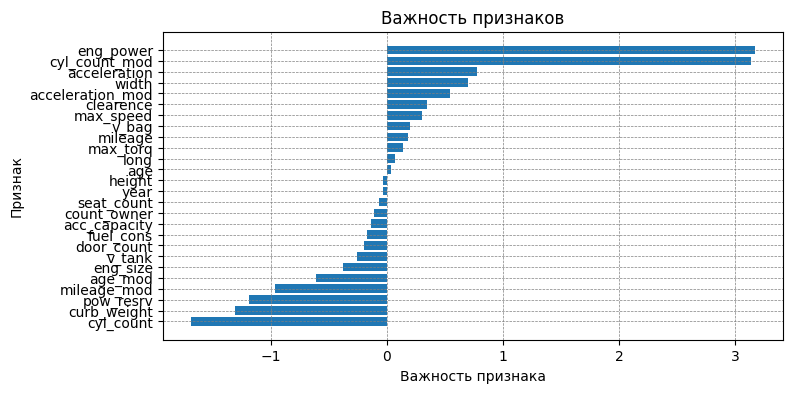

In [22]:
# Проверим важность признаков с точки зрения модели
importances = lr_pl.named_steps['linearregression'].coef_
importances = pd.Series(
    importances,
    index = X_train_num.columns
).sort_values()
# Построим диаграмму для наглядности
plt.figure(figsize=(8, 4))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

### Линейная регрессия (Lasso)

In [23]:
# Пайплайн обработки данных и обучения модели Lasso
lasso_pl = make_pipeline(col_transformer, Lasso())


param_grid_lasso = {
    'lasso__alpha': np.linspace(1, 50000, 50)
}
gs_lasso_pl = GridSearchCV(
                           lasso_pl,
                           param_grid=param_grid_lasso,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise'
)

gs_lasso_pl.fit(X_train_num, y_train)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_lasso_pl.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_lasso_pl.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_lasso_pl.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_lasso_pl.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_lasso_pl.best_estimator_,
                    'gs_lasso_pl.pkl',
                    compress=0)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
best_score: 0.32442446053028107
best_params: {'lasso__alpha': np.float64(1.0)}


In [24]:
# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train, gs_lasso_pl.best_estimator_.predict(X_train_num))}')
print(f'MSE {MSE(y_train, gs_lasso_pl.best_estimator_.predict(X_train_num))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test, gs_lasso_pl.best_estimator_.predict(X_test_num))}')
print(f'MSE {MSE(y_test, gs_lasso_pl.best_estimator_.predict(X_test_num))}')

Обучающая выборка
R2 0.32008618116378784
MSE 21.291772842407227
Тестовая выборка
R2 0.4079201817512512
MSE 12.486113548278809


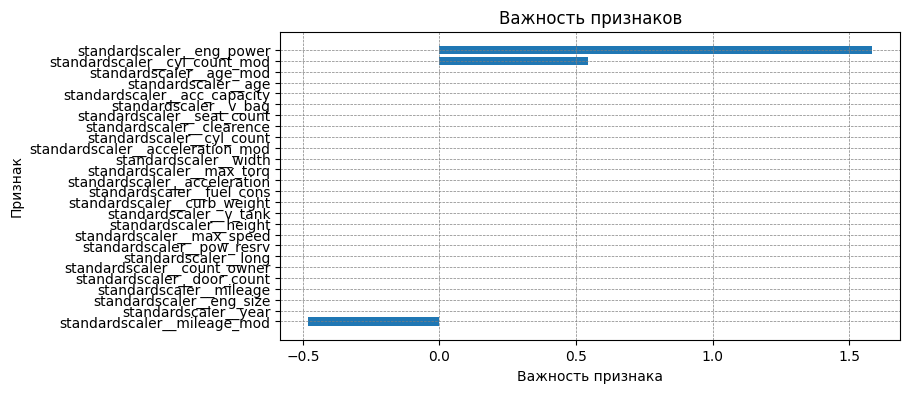

In [25]:
# Проверим важность признаков с точки зрения модели
importances = gs_lasso_pl.best_estimator_['lasso'].coef_
importances = pd.Series(
    importances,
    index=gs_lasso_pl.best_estimator_['columntransformer'].get_feature_names_out()
).sort_values()
# Построим диаграмму для наглядности
plt.figure(figsize=(8, 4))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
#plt.xlim([0, 20])
#plt.xticks(np.arange(0, 20, step=1), rotation=0)
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

### ElasticNet

In [26]:
# Пайплайн обработки данных и обучения модели ElasticNet
elnet_pl = make_pipeline(col_transformer, ElasticNet())

param_grid_elnet = {
    'elasticnet__alpha': np.linspace(1, 50000, 50),
    'elasticnet__l1_ratio': np.linspace(0.01, 1, 20),
}
gs_elnet_pl = GridSearchCV(
                           elnet_pl,
                           param_grid=param_grid_elnet,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise'
)

gs_elnet_pl.fit(X_train_num, y_train)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_elnet_pl.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_elnet_pl.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_elnet_pl.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_elnet_pl.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_elnet_pl.best_estimator_,
                    'gs_elnet_pl.pkl',
                    compress=0)

Fitting 4 folds for each of 1000 candidates, totalling 4000 fits
best_score: 0.3562881797552109
best_params: {'elasticnet__alpha': np.float64(1.0), 'elasticnet__l1_ratio': np.float64(0.01)}


In [27]:
# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train, gs_elnet_pl.best_estimator_.predict(X_train_num))}')
print(f'MSE {MSE(y_train, gs_elnet_pl.best_estimator_.predict(X_train_num))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test, gs_elnet_pl.best_estimator_.predict(X_test_num))}')
print(f'MSE {MSE(y_test, gs_elnet_pl.best_estimator_.predict(X_test_num))}')

Обучающая выборка
R2 0.351906955242157
MSE 20.2952938079834
Тестовая выборка
R2 0.44293612241744995
MSE 11.74767780303955


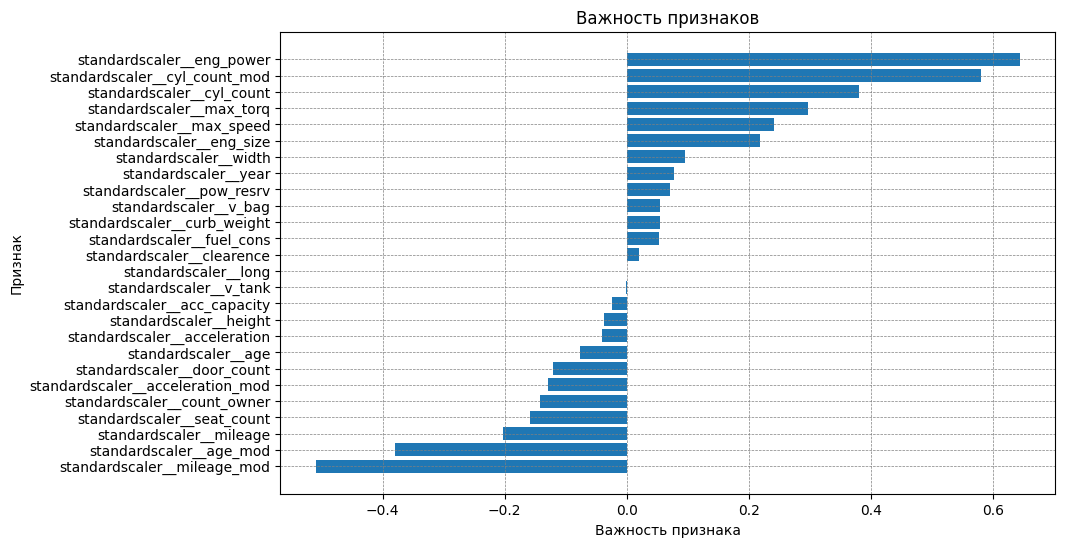

In [28]:
# Проверим важность признаков с точки зрения модели
importances = gs_elnet_pl.best_estimator_['elasticnet'].coef_
importances = pd.Series(
    importances,
    index=gs_elnet_pl.best_estimator_['columntransformer'].get_feature_names_out()
).sort_values()
# Построим диаграмму для наглядности
plt.figure(figsize=(10, 6))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

### Ridge

In [29]:
# Пайплайн обработки данных и обучения линейной модели
ridge_pl = make_pipeline(col_transformer, Ridge())

param_grid_ridge = {
    'ridge__alpha': np.linspace(1, 50000, 100)
}
gs_ridge_pl = GridSearchCV(
                           ridge_pl,
                           param_grid=param_grid_ridge,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise'
)

gs_ridge_pl.fit(X_train_num, y_train)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_ridge_pl.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_ridge_pl.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_ridge_pl.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_ridge_pl.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_ridge_pl.best_estimator_,
                    'gs_ridge_pl.pkl',
                    compress=0)

Fitting 4 folds for each of 100 candidates, totalling 400 fits
best_score: 0.42157092690467834
best_params: {'ridge__alpha': np.float64(1.0)}


In [30]:
# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train, gs_ridge_pl.best_estimator_.predict(X_train_num))}')
print(f'MSE {MSE(y_train, gs_ridge_pl.best_estimator_.predict(X_train_num))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test, gs_ridge_pl.best_estimator_.predict(X_test_num))}')
print(f'MSE {MSE(y_test, gs_ridge_pl.best_estimator_.predict(X_test_num))}')

Обучающая выборка
R2 0.4200030565261841
MSE 18.1628360748291
Тестовая выборка
R2 0.49683308601379395
MSE 10.611067771911621


Качество моделей только на числовых признаках невысокое.

## Модели на всех признаках

In [33]:
X_train = train[cat_features + num_features]
X_test = test[cat_features + num_features]

In [35]:
# Обновим набор преобразований столбцов
col_transformer = make_column_transformer(
    (
        OneHotEncoder(handle_unknown='ignore',
                      drop='first',
                      dtype='int16',
                      sparse_output=True),
        cat_features
    ),
    (
        StandardScaler(),
        num_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=True
)

### Линейная регрессия

In [36]:
# Пайплайн обработки данных и обучения Линейной регрессии
lr_pl_ext = make_pipeline(col_transformer, LinearRegression())
# Обучим модель
lr_pl_ext.fit(X_train, y_train)

# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train, lr_pl_ext.predict(X_train))}')
print(f'MSE {MSE(y_train, lr_pl_ext.predict(X_train))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test, lr_pl_ext.predict(X_test))}')
print(f'MSE {MSE(y_test, lr_pl_ext.predict(X_test))}')

# Сохраним модель
try:
    _ = joblib.dump(lr_pl_ext,
                    os.path.join(MODEL_PATH, 'lr_pl_ext.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(lr_pl_ext,
                    'lr_pl_ext.pkl',
                    compress=0)

Обучающая выборка
R2 0.9174765944480896
MSE 2.5842537879943848
Тестовая выборка
R2 0.8135755062103271


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE 3.9314258098602295


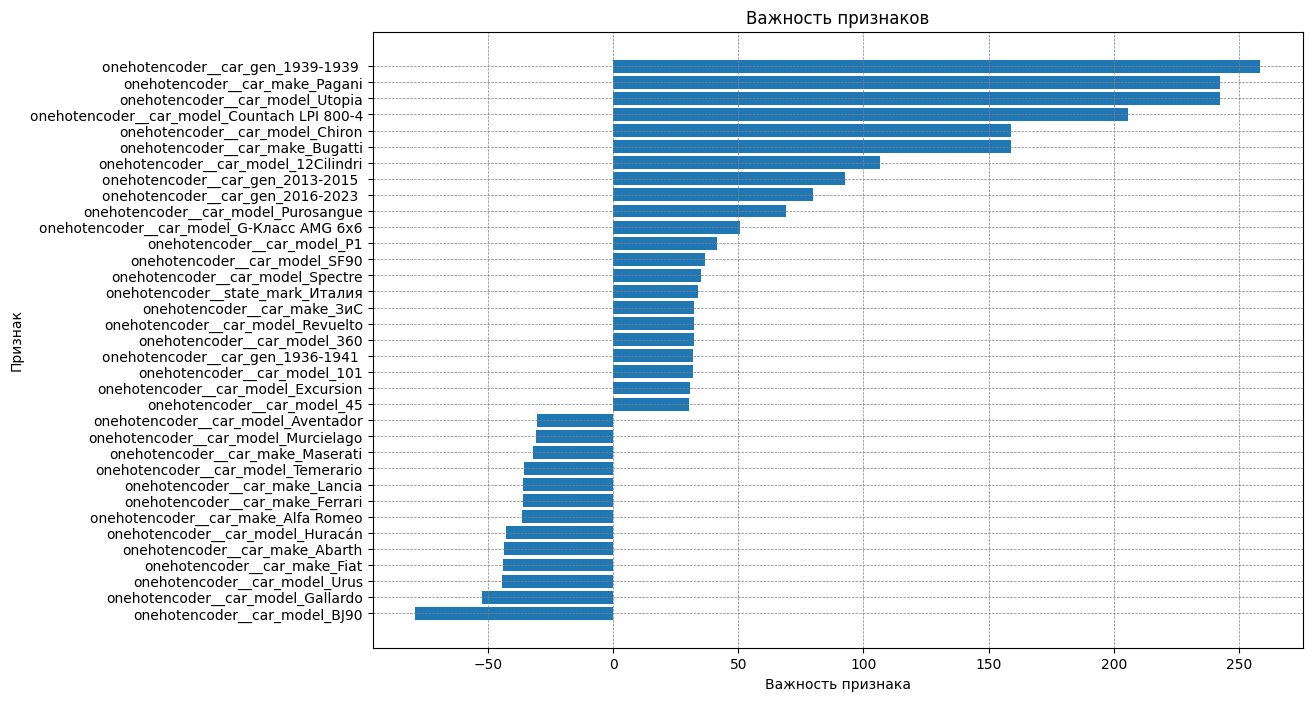

In [45]:
# Проверим важность признаков с точки зрения модели
importances = lr_pl_ext.named_steps['linearregression'].coef_
importances = pd.Series(
    importances,
    index = lr_pl_ext[:-1].get_feature_names_out()
).sort_values()
importances = importances[abs(importances)>30]
# Построим диаграмму для наглядности
plt.figure(figsize=(12, 8))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

### Линейная регрессия (Lasso)

In [46]:
# Пайплайн обработки данных и обучения модели Lasso
lasso_pl_ext = make_pipeline(col_transformer, Lasso())


param_grid_lasso = {
    'lasso__alpha': np.linspace(1, 50000, 50)
}
gs_lasso_pl_ext = GridSearchCV(
                           lasso_pl_ext,
                           param_grid=param_grid_lasso,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise'
)

gs_lasso_pl_ext.fit(X_train, y_train)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_lasso_pl_ext.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_lasso_pl_ext.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_lasso_pl_ext.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_lasso_pl_ext.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_lasso_pl_ext.best_estimator_,
                    'gs_lasso_pl_ext.pkl',
                    compress=0)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
best_score: 0.32440902292728424
best_params: {'lasso__alpha': np.float64(1.0)}


In [47]:
# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train, gs_lasso_pl_ext.best_estimator_.predict(X_train))}')
print(f'MSE {MSE(y_train, gs_lasso_pl_ext.best_estimator_.predict(X_train))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test, gs_lasso_pl_ext.best_estimator_.predict(X_test))}')
print(f'MSE {MSE(y_test, gs_lasso_pl_ext.best_estimator_.predict(X_test))}')

Обучающая выборка
R2 0.3200753331184387
MSE 21.292112350463867
Тестовая выборка
R2 0.4079133868217468


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE 12.486257553100586


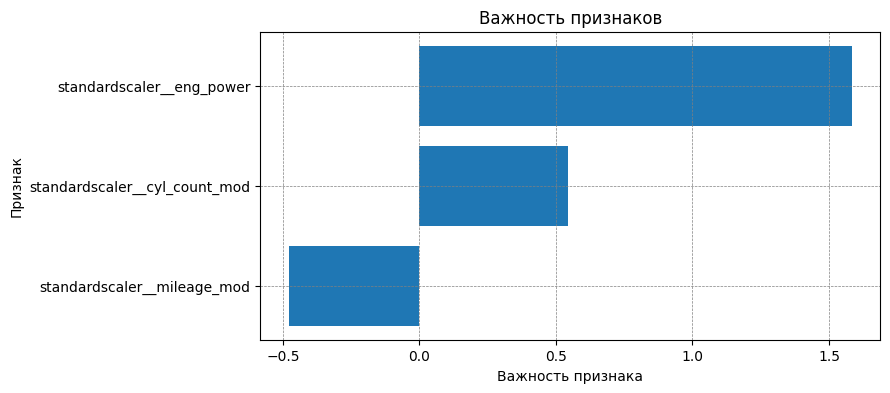

In [61]:
# Проверим важность признаков с точки зрения модели
importances = gs_lasso_pl_ext.best_estimator_['lasso'].coef_
importances = pd.Series(
    importances,
    index=gs_lasso_pl_ext.best_estimator_['columntransformer'].get_feature_names_out()
).sort_values()
importances = importances[abs(importances)>0.05]
# Построим диаграмму для наглядности
plt.figure(figsize=(8, 4))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
#plt.xlim([0, 20])
#plt.xticks(np.arange(0, 20, step=1), rotation=0)
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

### ElasticNet

In [62]:
# Пайплайн обработки данных и обучения модели ElastiNet
elnet_pl_ext = make_pipeline(col_transformer, ElasticNet())

param_grid_elnet = {
    'elasticnet__alpha': np.linspace(1, 50000, 20),
    'elasticnet__l1_ratio': np.linspace(0.01, 1, 10),
}
gs_elnet_pl_ext = GridSearchCV(
                           elnet_pl_ext,
                           param_grid=param_grid_elnet,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise'
)

gs_elnet_pl_ext.fit(X_train, y_train)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_elnet_pl_ext.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_elnet_pl_ext.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_elnet_pl_ext.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_elnet_pl_ext.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_elnet_pl_ext.best_estimator_,
                    'gs_elnet_pl_ext.pkl',
                    compress=0)

Fitting 4 folds for each of 200 candidates, totalling 800 fits
best_score: 0.36108145117759705
best_params: {'elasticnet__alpha': np.float64(1.0), 'elasticnet__l1_ratio': np.float64(0.01)}


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1004.229248046875, tolerance: 410.5167541503906
  model = cd_fast.sparse_enet_coordinate_descent(


In [63]:
# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train, gs_elnet_pl_ext.best_estimator_.predict(X_train))}')
print(f'MSE {MSE(y_train, gs_elnet_pl_ext.best_estimator_.predict(X_train))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test, gs_elnet_pl_ext.best_estimator_.predict(X_test))}')
print(f'MSE {MSE(y_test, gs_elnet_pl_ext.best_estimator_.predict(X_test))}')

Обучающая выборка
R2 0.3566615581512451
MSE 20.146400451660156
Тестовая выборка
R2 0.4495408535003662


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE 11.608393669128418


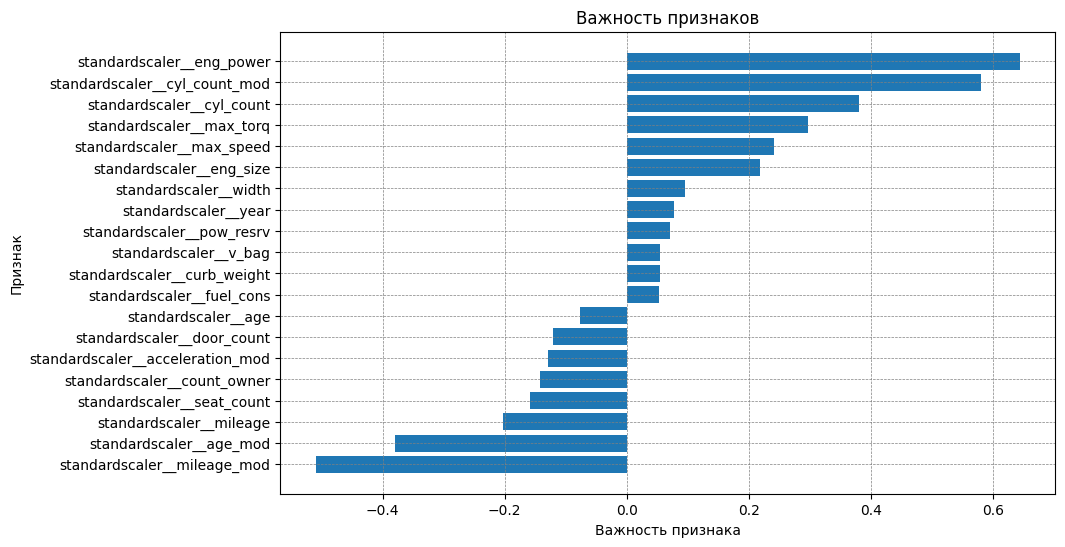

In [64]:
# Проверим важность признаков с точки зрения модели
importances = gs_elnet_pl.best_estimator_['elasticnet'].coef_
importances = pd.Series(
    importances,
    index=gs_elnet_pl.best_estimator_['columntransformer'].get_feature_names_out()
).sort_values()
importances = importances[abs(importances)>0.05]
# Построим диаграмму для наглядности
plt.figure(figsize=(10, 6))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

### Ridge

In [65]:
# Пайплайн обработки данных и обучения линейной модели
ridge_pl_ext = make_pipeline(col_transformer, Ridge())

param_grid_ridge = {
    'ridge__alpha': np.linspace(1, 50000, 50)
}
gs_ridge_pl_ext = GridSearchCV(
                           ridge_pl_ext,
                           param_grid=param_grid_ridge,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise'
)

gs_ridge_pl_ext.fit(X_train, y_train)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_ridge_pl_ext.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_ridge_pl_ext.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_ridge_pl_ext.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_ridge_pl_ext.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_ridge_pl_ext.best_estimator_,
                    'gs_ridge_pl_ext.pkl',
                    compress=0)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
best_score: 0.7960239201784134
best_params: {'ridge__alpha': np.float64(1.0)}


In [66]:
# Вычислим метрики
print('Обучающая выборка')
print(f'R2 {r2_score(y_train, gs_ridge_pl_ext.best_estimator_.predict(X_train))}')
print(f'MSE {MSE(y_train, gs_ridge_pl_ext.best_estimator_.predict(X_train))}')
print('Тестовая выборка')
print(f'R2 {r2_score(y_test, gs_ridge_pl_ext.best_estimator_.predict(X_test))}')
print(f'MSE {MSE(y_test, gs_ridge_pl_ext.best_estimator_.predict(X_test))}')

Обучающая выборка
R2 0.8991859555244446
MSE 3.1570327281951904
Тестовая выборка
R2 0.8232532739639282


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE 3.7273356914520264


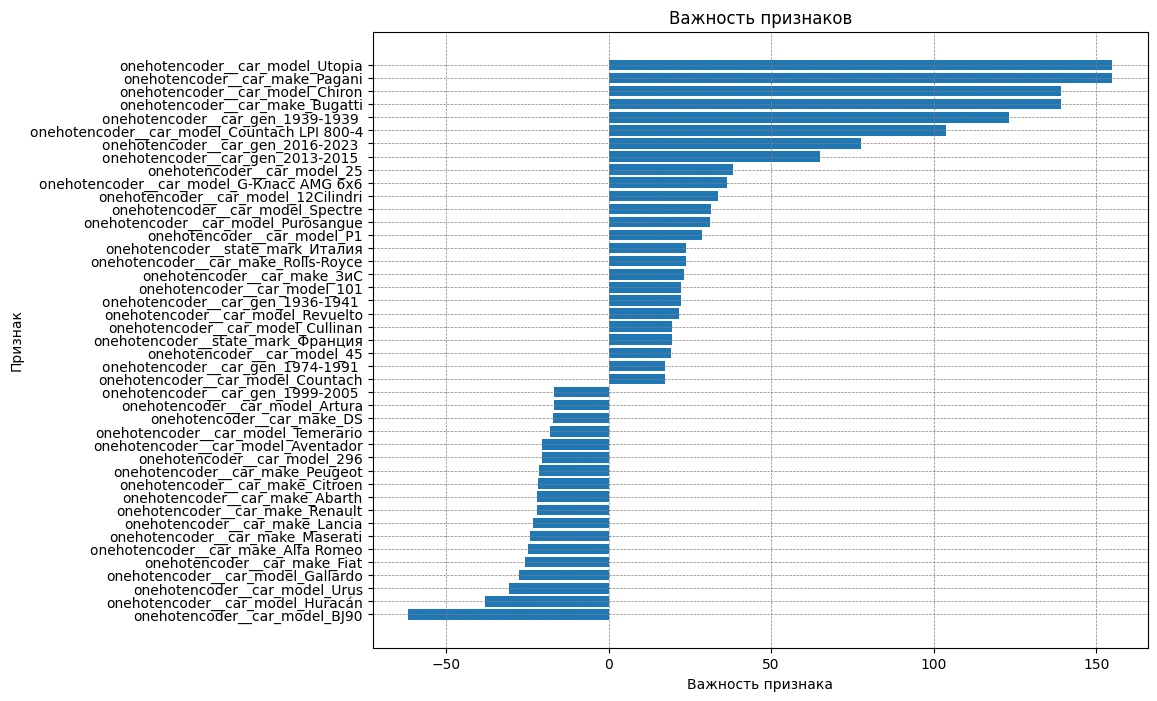

In [71]:
# Проверим важность признаков с точки зрения модели
importances = gs_ridge_pl_ext.best_estimator_['ridge'].coef_
importances = pd.Series(
    importances,
    index=gs_ridge_pl_ext.best_estimator_['columntransformer'].get_feature_names_out()
).sort_values()
importances = importances[abs(importances)>15]
# Построим диаграмму для наглядности
plt.figure(figsize=(10, 8))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

## Бизнес-метрика

Возьмём в качестве метрики долю верно спрогнозированных цен, при этом ошибка недопрогноза и перепрогноза будет учитываться по-разному:
- по недопрогнозов учитываем те прогнозы, которые в пределах отклонения under_est,
- по перепрогнозам - те прогнозы, которые в пределах отклонения over_est.  
Т.е. среди всех предсказанных цен на авто посчитаем долю прогнозов, отличающихся от реальных цен на эти авто не более чем на `under_est`% в сторону уменьшения и не более чем на `over_est`% в сторону увеличения.

In [72]:
def good_prediction_part(y_true, y_pred, under_est=0.05, over_est=0.10):
    deviations = abs(y_pred - y_true) / y_true

    result = (((deviations - 1 <= over_est) & (deviations > 1)).sum() +
              ((1 - deviations >= under_est) & (deviations < 1)).sum()) / len(y_true)

    return result

In [73]:
# Вычислим метрику у обученных моделей
print('Обучающая выборка')
print(f'{"good_prediction_part (LinearRegression numeric)":<50} {good_prediction_part(y_train, lr_pl.predict(X_train_num)):.10}')
print(f'{"good_prediction_part (LinearRegression ext)":<50} {good_prediction_part(y_train, lr_pl_ext.predict(X_train)):.10}')
print(f'{"good_prediction_part (Lasso numeric)":<50} {good_prediction_part(y_train, gs_lasso_pl.best_estimator_.predict(X_train_num)):.10}')
print(f'{"good_prediction_part (Lasso ext)":<50} {good_prediction_part(y_train, gs_lasso_pl_ext.best_estimator_.predict(X_train)):.10}')
print(f'{"good_prediction_part (ElasticNet numeric)":<50} {good_prediction_part(y_train, gs_elnet_pl.best_estimator_.predict(X_train_num)):.10}')
print(f'{"good_prediction_part (ElasticNet ext)":<50} {good_prediction_part(y_train, gs_elnet_pl_ext.best_estimator_.predict(X_train)):.10}')
print(f'{"good_prediction_part (Ridge numeric)":<50} {good_prediction_part(y_train, gs_ridge_pl.best_estimator_.predict(X_train_num)):.10}')
print(f'{"good_prediction_part (Ridge ext)":<50} {good_prediction_part(y_train, gs_ridge_pl_ext.best_estimator_.predict(X_train)):.10}')
print()
print('Тестовая выборка')
print(f'{"good_prediction_part (LinearRegression numeric)":<50} {good_prediction_part(y_test, lr_pl.predict(X_test_num)):.10}')
print(f'{"good_prediction_part (LinearRegression ext)":<50} {good_prediction_part(y_test, lr_pl_ext.predict(X_test)):.10}')
print(f'{"good_prediction_part (Lasso numeric)":<50} {good_prediction_part(y_test, gs_lasso_pl.best_estimator_.predict(X_test_num)):.10}')
print(f'{"good_prediction_part (Lasso ext)":<50} {good_prediction_part(y_test, gs_lasso_pl_ext.best_estimator_.predict(X_test)):.10}')
print(f'{"good_prediction_part (ElasticNet numeric)":<50} {good_prediction_part(y_test, gs_elnet_pl.best_estimator_.predict(X_test_num)):.10}')
print(f'{"good_prediction_part (ElasticNet ext)":<50} {good_prediction_part(y_test, gs_elnet_pl_ext.best_estimator_.predict(X_test)):.10}')
print(f'{"good_prediction_part (Ridge numeric)":<50} {good_prediction_part(y_test, gs_ridge_pl.best_estimator_.predict(X_test_num)):.10}')
print(f'{"good_prediction_part (Ridge ext)":<50} {good_prediction_part(y_test, gs_ridge_pl_ext.best_estimator_.predict(X_test)):.10}')

Обучающая выборка
good_prediction_part (LinearRegression numeric)    0.5986986139
good_prediction_part (LinearRegression ext)        0.823099984
good_prediction_part (Lasso numeric)               0.754094484
good_prediction_part (Lasso ext)                   0.7542470498
good_prediction_part (ElasticNet numeric)          0.6873164443
good_prediction_part (ElasticNet ext)              0.6928698385
good_prediction_part (Ridge numeric)               0.598912206
good_prediction_part (Ridge ext)                   0.8123669817

Тестовая выборка
good_prediction_part (LinearRegression numeric)    0.598266866
good_prediction_part (LinearRegression ext)        0.8024288286
good_prediction_part (Lasso numeric)               0.752051994


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


good_prediction_part (Lasso ext)                   0.7519299423
good_prediction_part (ElasticNet numeric)          0.6823299667
good_prediction_part (ElasticNet ext)              0.6856253623
good_prediction_part (Ridge numeric)               0.5990296891


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


good_prediction_part (Ridge ext)                   0.7949531627


Лучший результат среди рассмотренных линейных моделей показала линейная регрессия на всех признаках.